# Interacting with the World Bank v2 API

In this project, you will build a complete data workflow: API consumption, DataFrame transformation, visual analysis, and SQL database loading.

## Exercise Context

You will work with the public World Bank v2 API (no authentication required). The goal is to analyze the socioeconomic and environmental evolution of 5 countries chosen by you between 2010 and 2024.

### Dataset Selection

1. Choose 5 countries (ISO3) that interest you.
2. Choose the indicators you want to analyze.
3. Suggested indicators (optional):

- `SP.POP.TOTL`: Total population
- `NY.GDP.PCAP.CD`: GDP per capita (current USD)
- `EN.ATM.CO2E.PC`: CO2 emissions per capita (metric tons)
- `SP.DYN.LE00.IN`: Life expectancy at birth (years)

Base API URL: `https://api.worldbank.org/v2`

## Technical Requirements

You must work in a `.ipynb` file and use:

- `requests`
- `pandas`
- `matplotlib` and/or `seaborn`
- `sqlalchemy`


## Step 1: Prepare the environment

Install dependencies:

```bash
pip install requests pandas matplotlib seaborn sqlalchemy
```

Create a notebook, for example: `src/world_bank_analysis.ipynb`.

In [1]:
pip install requests pandas matplotlib seaborn sqlalchemy


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Step 2: Explore the API

Review these reference endpoints:

- Countries: `https://api.worldbank.org/v2/country`
- Indicators: `https://api.worldbank.org/v2/indicator`

Check the response structure. The API paginates results (usually up to `per_page=50`), so you should plan a strategy to loop through pages and store all the information you need.

Example request in Python (template):

```python
import requests

url = "https://api.worldbank.org/v2/country"
params = {
    "format": "json",
    "per_page": 50,
    "page": 1
}

response = requests.get(url, params=params, timeout=30)
response.raise_for_status()
payload = response.json()

# payload[0] -> pagination metadata
# payload[1] -> current page data
print("Metadata:", payload[0])
print("First item:", payload[1][0])
```

*IMPORTANT:* The code above is only a guide. In the link below you can find all the information needed to make API calls:

https://datahelpdesk.worldbank.org/knowledgebase/articles/898581

In [41]:
import requests
import pandas as pd

url = "https://api.worldbank.org/v2/country"
params = {
    "format": "json",
    "per_page": 50,
    "page": 1
}

response = requests.get(url, params=params, timeout=30)
response.raise_for_status()
payload = response.json()

total_pages = payload[0]['pages']
total_records = payload[0]['total']
print(f"Total pages: {total_pages}")
print(f"Total countries: {total_records}")

all_countries = []

for page_num in range(1, total_pages + 1):
    params['page'] = page_num
    response = requests.get(url, params=params, timeout=30)
    response.raise_for_status()
    payload = response.json()
    
    for item in payload[1]:
        all_countries.append({
            'id': item['id'],
            'iso2Code': item['iso2Code'],
            'name': item['name'],
            'region_id': item['region']['id'],
            'region_iso2code': item['region']['iso2code'],
            'region_value': item['region']['value'],
            'capital_city': item.get('capitalCity', ''),
            'longitude': item.get('longitude', ''),
            'latitude': item.get('latitude', ''),
            'income_level': item['incomeLevel']['value']
        })


df_countries = pd.DataFrame(all_countries)

selected_countries = ['ESP', 'DEU', 'GBR', 'USA']  # Spain, Germany, UK
df_countries = df_countries[df_countries['id'].isin(selected_countries)]

print(f"\n✓ Filtered for {len(df_countries)} countries: Spain, Germany, UK")
print(f"\nFiltered countries:")
df_countries

Total pages: 6
Total countries: 296

✓ Filtered for 4 countries: Spain, Germany, UK

Filtered countries:


,id,iso2Code,name,region_id,region_iso2code,region_value,capital_city,longitude,latitude,income_level
70,DEU,DE,Germany,ECS,Z7,Europe & Central Asia,Berlin,13.4115,52.5235,High income
91,ESP,ES,Spain,ECS,Z7,Europe & Central Asia,Madrid,-3.70327,40.4167,High income
103,GBR,GB,United Kingdom,ECS,Z7,Europe & Central Asia,London,-0.126236,51.5002,High income
280,USA,US,United States,NAC,XU,North America,Washington D.C.,-77.032,38.8895,High income


## Step 3: Download data

Download 2010-2024 time series for the countries and indicators you selected.

Goal:

- Consume the API for multiple countries and indicators
- Handle pagination when needed
- Store responses in a temporary structure (list of dictionaries)

In [45]:
import requests
import pandas as pd



countries = ['ESP', 'DEU', 'GBR']  
country_names = {'ESP': 'Spain', 'DEU': 'Germany', 'UK': 'United Kingdom'}


indicators = {
    'SP.POP.TOTL': 'Total Population',
    'NY.GDP.PCAP.CD': 'GDP per capita (USD)',
    'EN.ATM.CO2E.PC': 'CO2 emissions per capita (metric tons)',
    'SP.DYN.LE00.IN': 'Life expectancy at birth (years)'
}


start_year = 2010
end_year = 2024

base_url = "https://api.worldbank.org/v2"

all_data = []

for country_code in countries:
    for indicator_code, indicator_name in indicators.items():
        url = f"{base_url}/country/{country_code}/indicator/{indicator_code}"
        params = {
            'date': f'{start_year}:{end_year}',
            'format': 'json',
            'per_page': 500  
        }
        
        try:
            response = requests.get(url, params=params, timeout=30)
            response.raise_for_status()
            payload = response.json()
            
            if len(payload) > 1 and payload[1]:
                for entry in payload[1]:
                    if entry['value'] is not None:  
                        all_data.append({
                            'country_code': entry['country']['id'],
                            'country_name': entry['country']['value'],
                            'indicator_code': entry['indicator']['id'],
                            'indicator_name': indicator_name,
                            'year': int(entry['date']),
                            'value': entry['value']
                        })
            else:
                print("No data")
        except Exception as e:
            print(f"Error: {str(e)[:50]}")

df_worldbank = pd.DataFrame(all_data)

if len(df_worldbank) > 0:
    print(f"Years covered: {df_worldbank['year'].min()} - {df_worldbank['year'].max()}")
    print(f"\nFirst few rows:")
    display(df_worldbank.head(10))
else:
    print("No data.")

No data
No data
No data
Years covered: 2010 - 2024

First few rows:


,country_code,country_name,indicator_code,indicator_name,year,value
0,ES,Spain,SP.POP.TOTL,Total Population,2024,48848840.0
1,ES,Spain,SP.POP.TOTL,Total Population,2023,48352528.0
2,ES,Spain,SP.POP.TOTL,Total Population,2022,47786102.0
3,ES,Spain,SP.POP.TOTL,Total Population,2021,47443821.0
4,ES,Spain,SP.POP.TOTL,Total Population,2020,47359424.0
5,ES,Spain,SP.POP.TOTL,Total Population,2019,47118501.0
6,ES,Spain,SP.POP.TOTL,Total Population,2018,46782011.0
7,ES,Spain,SP.POP.TOTL,Total Population,2017,46571232.0
8,ES,Spain,SP.POP.TOTL,Total Population,2016,46458139.0
9,ES,Spain,SP.POP.TOTL,Total Population,2015,46422303.0


## Step 4: Transform responses into DataFrames

Create one table (DataFrame) per indicator to make country comparisons easier.

Suggested columns for each table:

- `country`
- `year`
- `value`

Minimum cleaning:

- Remove rows with null `value` when needed
- Convert `year` to integer
- Convert `value` to numeric

In [47]:
df_clean = df_worldbank.copy()

df_clean = df_clean[df_clean['value'].notna()]

# Convertir año a numerico
df_clean['year'] = df_clean['year'].astype(int)
df_clean['value'] = pd.to_numeric(df_clean['value'], errors='coerce')

df_clean = df_clean[df_clean['value'].notna()]

indicator_dataframes = {}

for indicator_code, indicator_name in indicators.items():
    df_indicator = df_clean[df_clean['indicator_code'] == indicator_code][['country_name', 'year', 'value']].copy()
    
    df_indicator.columns = ['country', 'year', 'value']
    
    df_indicator = df_indicator.sort_values(['country', 'year']).reset_index(drop=True)
    
    key_name = indicator_code.replace('.', '_')
    indicator_dataframes[key_name] = df_indicator
    
    print(f"\n{indicator_name} ({indicator_code}):")
    print(f"  Countries: {df_indicator['country'].nunique()}")
    print(f"  Years: {df_indicator['year'].min()} - {df_indicator['year'].max()}")

df_population = indicator_dataframes['SP_POP_TOTL']
df_gdp_per_capita = indicator_dataframes['NY_GDP_PCAP_CD']
df_co2_emissions = indicator_dataframes['EN_ATM_CO2E_PC']
df_life_expectancy = indicator_dataframes['SP_DYN_LE00_IN']

print("\n" + "="*60)
print("Created DataFrames:")
print("  - df_population: Total Population")
print("  - df_gdp_per_capita: GDP per capita (USD)")
print("  - df_co2_emissions: CO2 emissions per capita")
print("  - df_life_expectancy: Life expectancy at birth")
print("="*60)

display(df_population.head(10))


Total Population (SP.POP.TOTL):
  Countries: 3
  Years: 2010 - 2024

GDP per capita (USD) (NY.GDP.PCAP.CD):
  Countries: 3
  Years: 2010 - 2024

CO2 emissions per capita (metric tons) (EN.ATM.CO2E.PC):
  Countries: 0
  Years: nan - nan

Life expectancy at birth (years) (SP.DYN.LE00.IN):
  Countries: 3
  Years: 2010 - 2023

Created DataFrames:
  - df_population: Total Population
  - df_gdp_per_capita: GDP per capita (USD)
  - df_co2_emissions: CO2 emissions per capita
  - df_life_expectancy: Life expectancy at birth


,country,year,value
0,Germany,2010,81776930.0
1,Germany,2011,80274983.0
2,Germany,2012,80425823.0
3,Germany,2013,80645605.0
4,Germany,2014,80982500.0
5,Germany,2015,81686611.0
6,Germany,2016,82348669.0
7,Germany,2017,82657002.0
8,Germany,2018,82905782.0
9,Germany,2019,83092962.0


## Step 5: Analysis and visualizations

Create at least 2 charts and explain findings in Markdown cells.

Examples:

1. Line chart: evolution of one indicator by country (2010-2024)
2. Scatter plot: relationship between two indicators for a recent year



### Visualization 1: GDP per Capita Evolution (2010-2024) for the last 14 years



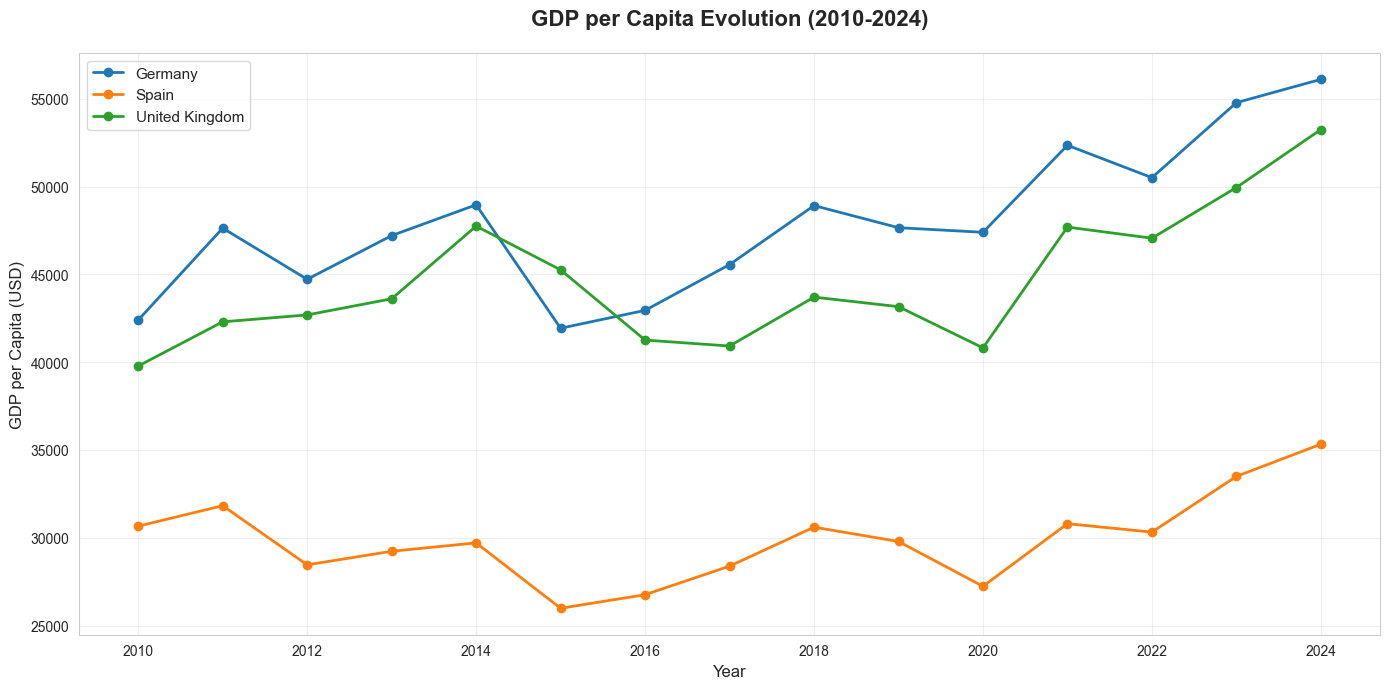

GDP PER CAPITA SUMMARY (USD)

Germany:
  2010: $42,396.97
  2024: $56,103.73
  Growth: +32.33%

Spain:
  2010: $30,658.74
  2024: $35,326.77
  Growth: +15.23%

United Kingdom:
  2010: $39,778.32
  2024: $53,246.37
  Growth: +33.86%


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

plt.figure(figsize=(14, 7))

for country in df_gdp_per_capita['country'].unique():
    country_data = df_gdp_per_capita[df_gdp_per_capita['country'] == country]
    plt.plot(country_data['year'], country_data['value'], 
             marker='o', linewidth=2, markersize=6, label=country)

plt.title('GDP per Capita Evolution (2010-2024)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('GDP per Capita (USD)', fontsize=12)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("="*70)
print("GDP PER CAPITA SUMMARY (USD)")
print("="*70)
for country in df_gdp_per_capita['country'].unique():
    country_data = df_gdp_per_capita[df_gdp_per_capita['country'] == country]
    start_value = country_data[country_data['year'] == country_data['year'].min()]['value'].values[0]
    end_value = country_data[country_data['year'] == country_data['year'].max()]['value'].values[0]
    growth = ((end_value - start_value) / start_value) * 100
    
    print(f"\n{country}:")
    print(f"  2010: ${start_value:,.2f}")
    print(f"  {country_data['year'].max()}: ${end_value:,.2f}")
    print(f"  Growth: {growth:+.2f}%")

### Visualization 2: GDP vs Esperanza de vida (2022)



Selected year for analysis: 2023


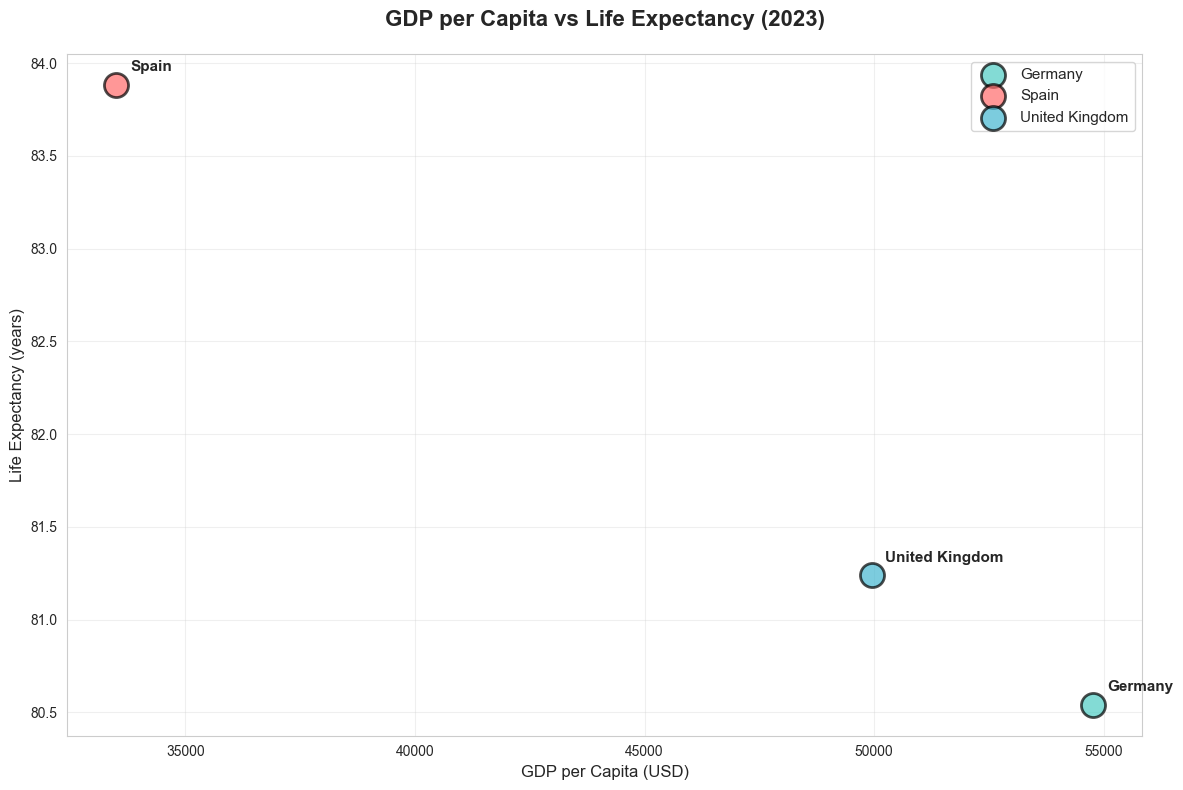

COMPARATIVE DATA - YEAR 2023

Germany:
  GDP per Capita: $54,776.77
  Life Expectancy: 80.54 years

Spain:
  GDP per Capita: $33,493.22
  Life Expectancy: 83.88 years

United Kingdom:
  GDP per Capita: $49,944.47
  Life Expectancy: 81.24 years
Correlacion: -1.000
Fuerte positiva correlacion entre GDP y esperanza de vida


In [50]:

recent_years = sorted(df_gdp_per_capita['year'].unique(), reverse=True)

selected_year = None
for year in recent_years:
    gdp_data = df_gdp_per_capita[df_gdp_per_capita['year'] == year]
    life_data = df_life_expectancy[df_life_expectancy['year'] == year]
    
    if len(gdp_data) >= 3 and len(life_data) >= 3:
        selected_year = year
        break

print(f"Selected year for analysis: {selected_year}")

df_gdp_year = df_gdp_per_capita[df_gdp_per_capita['year'] == selected_year][['country', 'value']]
df_gdp_year.columns = ['country', 'gdp_per_capita']

df_life_year = df_life_expectancy[df_life_expectancy['year'] == selected_year][['country', 'value']]
df_life_year.columns = ['country', 'life_expectancy']

df_scatter = df_gdp_year.merge(df_life_year, on='country')

plt.figure(figsize=(12, 8))
colors = {'Spain': '#FF6B6B', 'Germany': '#4ECDC4', 'United Kingdom': '#45B7D1'}

for country in df_scatter['country'].unique():
    country_data = df_scatter[df_scatter['country'] == country]
    plt.scatter(country_data['gdp_per_capita'], country_data['life_expectancy'],
               s=300, alpha=0.7, c=colors.get(country, '#95A5A6'), 
               edgecolors='black', linewidth=2, label=country)
    
    plt.annotate(country, 
                (country_data['gdp_per_capita'].values[0], 
                 country_data['life_expectancy'].values[0]),
                fontsize=11, fontweight='bold', 
                xytext=(10, 10), textcoords='offset points')

plt.title(f'GDP per Capita vs Life Expectancy ({selected_year})', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('GDP per Capita (USD)', fontsize=12)
plt.ylabel('Life Expectancy (years)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11, loc='best')
plt.tight_layout()
plt.show()


print(f"COMPARATIVE DATA - YEAR {selected_year}")

for _, row in df_scatter.iterrows():
    print(f"\n{row['country']}:")
    print(f"  GDP per Capita: ${row['gdp_per_capita']:,.2f}")
    print(f"  Life Expectancy: {row['life_expectancy']:.2f} years")

correlation = df_scatter['gdp_per_capita'].corr(df_scatter['life_expectancy'])

print(f"Correlacion: {correlation:.3f}")
if abs(correlation) > 0.7:
    print("Fuerte positiva correlacion entre GDP y esperanza de vida")
elif correlation > 0.3:
    print("Moderada correlacion entre GPD y esperanza de vida")
else:
    print("Debil correlacion entre GPD y esperanza de vida")

## Step 6: Load results into an SQL database

Use SQLite with SQLAlchemy to persist data:

- Database: `world_bank_analysis.db`
- Teaching recommendation: one table per indicator (example: `indicator_gdp_per_capita`, `indicator_life_expectancy`, etc.)

Recommended flow:

1. Create an engine with SQLAlchemy
2. Save each DataFrame with `to_sql(..., if_exists="replace")`
3. Read a sample with `pd.read_sql()` to validate the load


In [51]:
from sqlalchemy import create_engine
import pandas as pd

database_name = 'world_bank_analysis.db'
engine = create_engine(f'sqlite:///{database_name}')

print(f"Creating SQLite database: {database_name}")

tables_to_save = {
    'indicator_population': df_population,
    'indicator_gdp_per_capita': df_gdp_per_capita,
    'indicator_co2_emissions': df_co2_emissions,
    'indicator_life_expectancy': df_life_expectancy
}

for table_name, dataframe in tables_to_save.items():
    try:
        dataframe.to_sql(table_name, engine, if_exists='replace', index=False)
        print(f"✓ Saved '{table_name}' - {len(dataframe)} records")
    except Exception as e:
        print(f"✗ Error saving '{table_name}': {str(e)[:50]}")

print(f"Location: {database_name}")
print(f"Total tables: {len(tables_to_save)}")
print("\nTable names:")
for table_name in tables_to_save.keys():
    print(f"  - {table_name}")

Creating SQLite database: world_bank_analysis.db
✓ Saved 'indicator_population' - 45 records
✓ Saved 'indicator_gdp_per_capita' - 45 records
✓ Saved 'indicator_co2_emissions' - 0 records
✓ Saved 'indicator_life_expectancy' - 42 records
Location: world_bank_analysis.db
Total tables: 4

Table names:
  - indicator_population
  - indicator_gdp_per_capita
  - indicator_co2_emissions
  - indicator_life_expectancy


### Validate Database Load

Read samples from each table to verify the data was saved correctly.

In [53]:
print("DATABASE VALIDATION - Reading samples from each table")

for table_name in tables_to_save.keys():
    print(f"\n📋 Table: {table_name}")
    # Read sample data from the table
    query = f"SELECT * FROM {table_name} LIMIT 5"
    df_sample = pd.read_sql(query, engine)
    
    print(f"Total records in table: ", end="")
    count_query = f"SELECT COUNT(*) as count FROM {table_name}"
    count_df = pd.read_sql(count_query, engine)
    print(f"{count_df['count'].values[0]}")
    
    print(f"\nSample data (first 5 rows):")
    display(df_sample)

engine.dispose()

DATABASE VALIDATION - Reading samples from each table

📋 Table: indicator_population
Total records in table: 45

Sample data (first 5 rows):


,country,year,value
0,Germany,2010,81776930.0
1,Germany,2011,80274983.0
2,Germany,2012,80425823.0
3,Germany,2013,80645605.0
4,Germany,2014,80982500.0



📋 Table: indicator_gdp_per_capita
Total records in table: 45

Sample data (first 5 rows):


,country,year,value
0,Germany,2010,42396.966598
1,Germany,2011,47630.976188
2,Germany,2012,44718.015921
3,Germany,2013,47206.835351
4,Germany,2014,48959.599120



📋 Table: indicator_co2_emissions
Total records in table: 0

Sample data (first 5 rows):


,country,year,value



📋 Table: indicator_life_expectancy
Total records in table: 42

Sample data (first 5 rows):


,country,year,value
0,Germany,2010,79.987805
1,Germany,2011,80.436585
2,Germany,2012,80.539024
3,Germany,2013,80.490244
4,Germany,2014,81.090244


## Closing

You already have everything you need to start!
Take your time exploring the API documentation and understanding the response structure.
If you have any questions during the process, contact your mentors.